In [9]:
import numpy as np
import pickle
import gym

Progress loaded from q_learning_progress.pkl, starting from episode 6000
Progress saved to q_learning_progress.pkl at episode 6000
Total episodes recorded: 6000


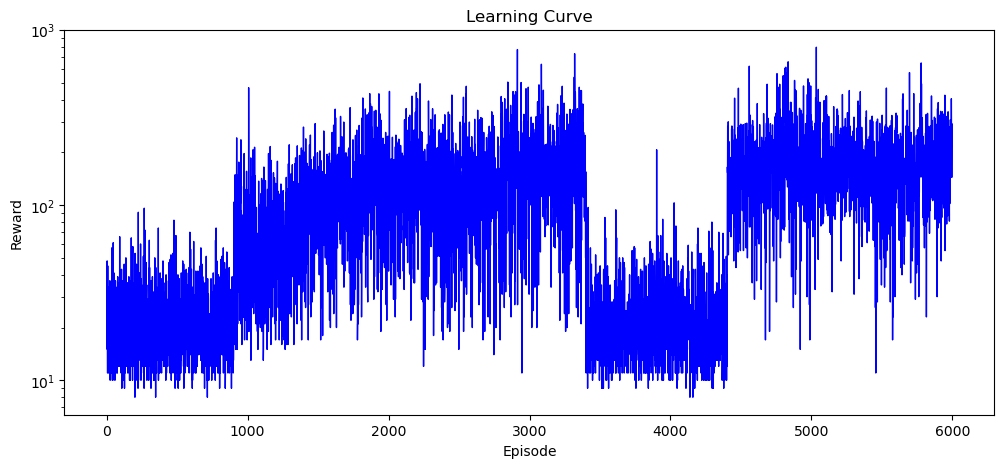

Sum of rewards from optimal strategy: 57677.0


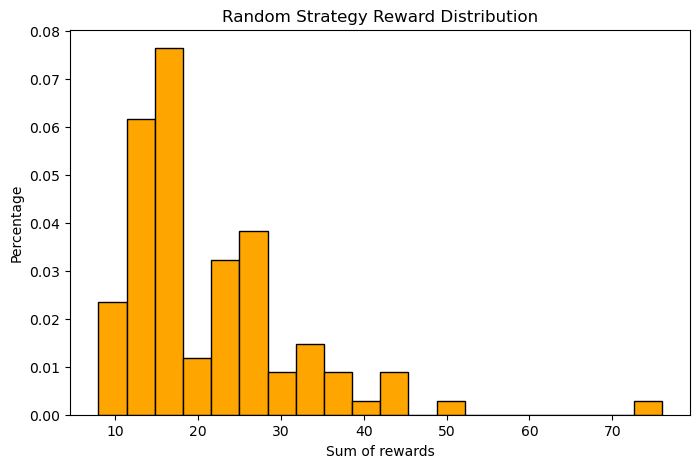

In [10]:
import numpy as np
import pickle
import gym
import matplotlib.pyplot as plt

class Q_Learning:
    def __init__(self, env, alpha, gamma, epsilon, numberEpisodes, numberOfBins, lowerBounds, upperBounds):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.actionNumber = env.action_space.n
        self.numberEpisodes = numberEpisodes
        self.numberOfBins = numberOfBins
        self.lowerBounds = lowerBounds
        self.upperBounds = upperBounds
        self.sumRewardsEpisode = []
        self.Qmatrix = np.random.uniform(low=0, high=1, size=(numberOfBins[0], numberOfBins[1], numberOfBins[2], numberOfBins[3], self.actionNumber))
        self.current_episode = 0  # Initialize episode counter

    def returnIndexState(self, state):
        stateIndex = []
        for i in range(len(state)):
            index = int(round((state[i] - self.lowerBounds[i]) / (self.upperBounds[i] - self.lowerBounds[i]) * (self.numberOfBins[i] - 1)))
            index = max(0, min(self.numberOfBins[i] - 1, index))
            stateIndex.append(index)
        return tuple(stateIndex)

    def selectAction(self, state, index):
        if index < 500:
            return np.random.choice(self.actionNumber)
        randomNumber = np.random.random()
        if index > 7000:
            self.epsilon = 0.999 * self.epsilon
        if randomNumber < self.epsilon:
            return np.random.choice(self.actionNumber)
        else:
            return np.argmax(self.Qmatrix[self.returnIndexState(state)])

    def simulateEpisodes(self, save_interval=100, save_file="q_learning_progress.pkl"):
        # Ensure rewards list is consistent with loaded episode count
        if len(self.sumRewardsEpisode) > self.current_episode:
            print(f"Warning: Trimming rewards list from {len(self.sumRewardsEpisode)} to {self.current_episode}")
            self.sumRewardsEpisode = self.sumRewardsEpisode[:self.current_episode]

        for indexEpisode in range(self.current_episode, self.numberEpisodes):  # Start from current_episode
            rewardsEpisode = []
            (stateS, _) = self.env.reset()
            stateS = list(stateS)
            print(f"Simulating episode {indexEpisode + 1}")
            terminalState = False
            while not terminalState:
                stateSIndex = self.returnIndexState(stateS)
                actionA = self.selectAction(stateS, indexEpisode)
                (stateSprime, reward, terminalState, _, _) = self.env.step(actionA)
                rewardsEpisode.append(reward)
                stateSprime = list(stateSprime)
                stateSprimeIndex = self.returnIndexState(stateSprime)
                QmaxPrime = np.max(self.Qmatrix[stateSprimeIndex])
                if not terminalState:
                    error = reward + self.gamma * QmaxPrime - self.Qmatrix[stateSIndex + (actionA,)]
                    self.Qmatrix[stateSIndex + (actionA,)] += self.alpha * error
                else:
                    error = reward - self.Qmatrix[stateSIndex + (actionA,)]
                    self.Qmatrix[stateSIndex + (actionA,)] += self.alpha * error
                stateS = stateSprime
            print(f"Sum of rewards for episode {indexEpisode + 1}: {np.sum(rewardsEpisode)}")
            self.sumRewardsEpisode.append(np.sum(rewardsEpisode))
            
            # Update current_episode
            self.current_episode = indexEpisode + 1
            
            # Save progress every save_interval episodes
            if (indexEpisode + 1) % save_interval == 0:
                self.save_progress(save_file)
        
        # Save progress after completing all episodes
        self.save_progress(save_file)

    def save_progress(self, filename="q_learning_progress.pkl"):
        data = {
            "Qmatrix": self.Qmatrix,
            "epsilon": self.epsilon,
            "sumRewardsEpisode": self.sumRewardsEpisode,
            "current_episode": self.current_episode  # Save current episode count
        }
        with open(filename, "wb") as f:
            pickle.dump(data, f)
        print(f"Progress saved to {filename} at episode {self.current_episode}")

    def load_progress(self, filename="q_learning_progress.pkl"):
        with open(filename, "rb") as f:
            data = pickle.load(f)
        self.Qmatrix = data["Qmatrix"]
        self.epsilon = data["epsilon"]
        self.sumRewardsEpisode = data["sumRewardsEpisode"]
        self.current_episode = data.get("current_episode", 0)  # Load episode count, default to 0
        
        # Validate length of sumRewardsEpisode
        if len(self.sumRewardsEpisode) > self.current_episode:
            print(f"Trimming rewards list from {len(self.sumRewardsEpisode)} to {self.current_episode}")
            self.sumRewardsEpisode = self.sumRewardsEpisode[:self.current_episode]
        
        print(f"Progress loaded from {filename}, starting from episode {self.current_episode}")

    def simulateLearnedStrategy(self, episodeNumber=100, timeSteps=1000):
        rewardsEpisodes = []
        for episodeIndex in range(episodeNumber):
            rewardsSingleEpisode = []
            (state, _) = self.env.reset()
            state = list(state)
            for timeIndex in range(timeSteps):
                stateIndex = self.returnIndexState(state)
                action = np.argmax(self.Qmatrix[stateIndex])
                (next_state, reward, terminalState, _, _) = self.env.step(action)
                rewardsSingleEpisode.append(reward)
                if terminalState:
                    break
                state = list(next_state)
            rewardsEpisodes.append(np.sum(rewardsSingleEpisode))
        return rewardsEpisodes, self.env

    def simulateRandomStrategy(self):
        env2 = gym.make('CartPole-v1')
        (currentState, _) = env2.reset()
        env2.render()
        episodeNumber = 100
        timeSteps = 1000
        sumRewardsEpisodes = []
        for episodeIndex in range(episodeNumber):
            rewardsSingleEpisode = []
            initial_state = env2.reset()
            for timeIndex in range(timeSteps):
                random_action = env2.action_space.sample()
                observation, reward, terminated, truncated, info = env2.step(random_action)
                rewardsSingleEpisode.append(reward)
                if terminated:
                    break
            sumRewardsEpisodes.append(np.sum(rewardsSingleEpisode))
        return sumRewardsEpisodes, env2


# Main code using Q_Learning
if __name__ == "__main__":
    # Initialize environment
    env = gym.make('CartPole-v1', render_mode="human")
    (state, _) = env.reset()
    
    # Define state bounds
    upperBounds = env.observation_space.high
    lowerBounds = env.observation_space.low
    cartVelocityMin, cartVelocityMax = -3, 3
    poleAngleVelocityMin, poleAngleVelocityMax = -10, 10
    upperBounds[1], upperBounds[3] = cartVelocityMax, poleAngleVelocityMax
    lowerBounds[1], lowerBounds[3] = cartVelocityMin, poleAngleVelocityMin
    
    # Define discretization bins
    numberOfBins = [30, 30, 30, 30]
    
    # Set hyperparameters
    alpha = 0.1
    gamma = 1
    epsilon = 0.2
    numberEpisodes = 6000  # Total desired episodes
    
    # Create an instance of Q_Learning
    Q1 = Q_Learning(env, alpha, gamma, epsilon, numberEpisodes, numberOfBins, lowerBounds, upperBounds)
    
    # Load previous progress if exists
    progress_file = "q_learning_progress.pkl"
    try:
        Q1.load_progress(progress_file)
    except FileNotFoundError:
        print("No saved progress found. Starting fresh.")
    
    # Run Q-learning with saving enabled
    Q1.simulateEpisodes(save_interval=2000, save_file=progress_file)
    
    # Debugging for recorded episodes
    print(f"Total episodes recorded: {len(Q1.sumRewardsEpisode)}")
    
    # Plotting and saving the learning curve
    plt.figure(figsize=(12, 5))
    plt.plot(range(len(Q1.sumRewardsEpisode)), Q1.sumRewardsEpisode, color='blue', linewidth=1)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.yscale('log')
    plt.title("Learning Curve")
    plt.savefig('convergence_fixed.png')
    plt.show()
    
    # Evaluate learned strategy
    obtainedRewardsOptimal, env1 = Q1.simulateLearnedStrategy()
    print("Sum of rewards from optimal strategy:", np.sum(obtainedRewardsOptimal))
    env1.close()
    
    # Evaluate random strategy
    obtainedRewardsRandom, env2 = Q1.simulateRandomStrategy()
    plt.figure(figsize=(8, 5))
    plt.hist(obtainedRewardsRandom, bins=20, color='orange', edgecolor='black', density=True)
    plt.xlabel('Sum of rewards')
    plt.ylabel('Percentage')
    plt.title("Random Strategy Reward Distribution")
    plt.savefig('histogram_fixed.png')
    plt.show()
    
    # Close environments
    env.close()
    env2.close()


        

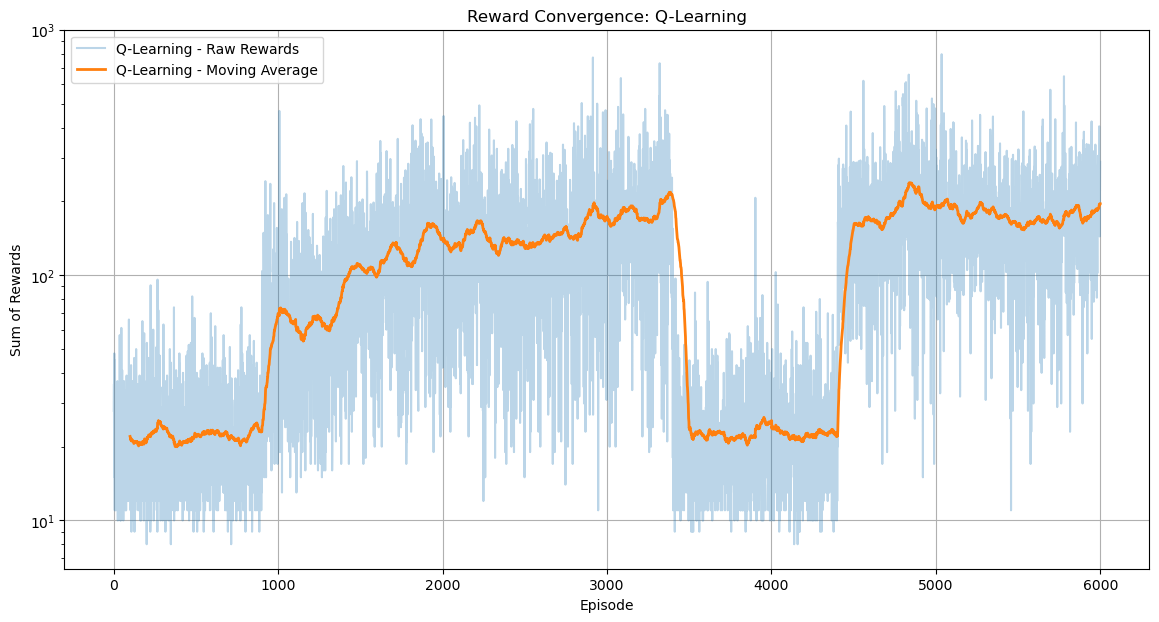

Average Reward per Episode (Q-Learning): 110.03733333333334
Episodes achieving threshold (Q-Learning): 1050


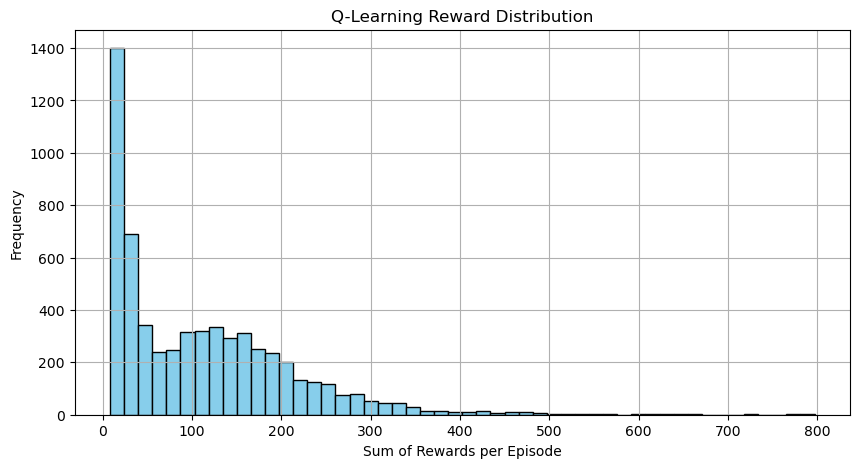

In [11]:


# Results and Analysis

# 4.1 Reward Maximization and Convergence Analysis
def plot_convergence(rewards, label, window=100):
    """ Plot reward convergence with a moving average for smoothing."""
    moving_avg = np.convolve(rewards, np.ones(window) / window, mode='valid')
    plt.plot(rewards, label=f'{label} - Raw Rewards', alpha=0.3)
    plt.plot(range(window - 1, len(rewards)), moving_avg, label=f'{label} - Moving Average', linewidth=2)

# Plotting Q-Learning rewards
plt.figure(figsize=(14, 7))
plot_convergence(Q1.sumRewardsEpisode, label="Q-Learning")

# If available, you can also add DQN reward data here for comparison:
# plot_convergence(DQN_rewards, label="DQN")

plt.xlabel('Episode')
plt.ylabel('Sum of Rewards')
plt.title('Reward Convergence: Q-Learning')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.savefig('reward_convergence.png')
plt.show()

# 4.2 Comparative Performance Analysis
# Calculate the average reward per episode and convergence statistics
average_reward_qlearning = np.mean(Q1.sumRewardsEpisode)
print("Average Reward per Episode (Q-Learning):", average_reward_qlearning)

# Placeholder for DQN data if available
# average_reward_dqn = np.mean(DQN_rewards)
# print("Average Reward per Episode (DQN):", average_reward_dqn)

# Calculate convergence speed based on last episodes reward stability
convergence_threshold = 195  # Typical reward threshold for CartPole success
converged_episodes_qlearning = sum([1 for reward in Q1.sumRewardsEpisode if reward >= convergence_threshold])
print("Episodes achieving threshold (Q-Learning):", converged_episodes_qlearning)

# 4.3 Visualizations and Graphs
# Q-Learning Reward Distribution
plt.figure(figsize=(10, 5))
plt.hist(Q1.sumRewardsEpisode, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Sum of Rewards per Episode')
plt.ylabel('Frequency')
plt.title('Q-Learning Reward Distribution')
plt.grid(True)
plt.savefig('qlearning_reward_distribution.png')
plt.show()



In [12]:
!git config --global user.name "Ojurere Gideon Odofin"
!git config --global user.email "ojureregideon@gmail.com"
